## 1. Importing Libraries

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data preprocessing 
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# For ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Miscellaneous
from tqdm import tqdm
import os
import random


## 2. Reading the Data

In [3]:
def read_dataset(data_path):
    data = []

    for label in os.listdir(data_path):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']: 
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(os.path.join(data_path,label)):
            data.append([os.path.join(data_path,label,image),real_label])
            
    return data

In [ ]:
# 2.1. Setting the Base Directory and Subdirectories:

In [4]:
image_data_paths = "C:\\Users\\tmost\\Documents\\Data-course\\Brain" # base directory where the brain image data is located
train_dir = os.path.join(image_data_paths,"Training")
test_dir = os.path.join(image_data_paths,"Testing")


train_data = shuffle(read_dataset(train_dir))
print(f'training image number: {len(train_data)}')

test_data = read_dataset(test_dir)
print(f'test image number: {len(test_data)}')

training image number: 2870
test image number: 394


In [5]:
train_data = pd.DataFrame(train_data, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
train_data.head(2)

,image_filepaths,tumor_class
0,C:\Users\tmost\Documents\Data-course\Brain\Tra...,glioma
1,C:\Users\tmost\Documents\Data-course\Brain\Tra...,notumor


In [6]:
test_data = pd.DataFrame(test_data, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
test_data.head(2)

,image_filepaths,tumor_class
0,C:\Users\tmost\Documents\Data-course\Brain\Tes...,glioma
1,C:\Users\tmost\Documents\Data-course\Brain\Tes...,notumor


## 3. Data Visualization Distribution for each class

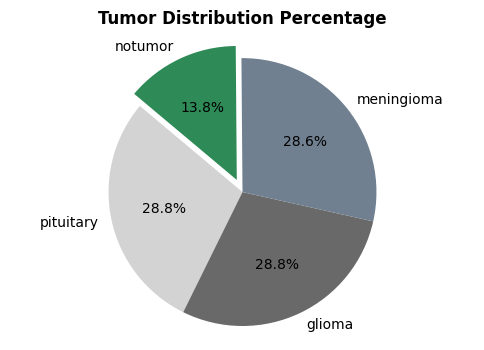

In [7]:
label_counts = train_data['tumor_class'].value_counts().to_dict()  # Count occurrences of each label
total_count = sum(label_counts.values())  
label_percentages = {label: count / total_count * 100 for label, count in label_counts.items()}  

# Create a pie chart
plt.figure(figsize=(6, 4))
colors = ['lightgray','dimgray', 'slategrey','seagreen']
explode = (0, 0,0,0.1) #Explode the 1st slice (optional, for emphasis)
plt.pie(label_percentages.values(), labels=label_percentages.keys(), autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Tumor Distribution Percentage',weight='bold')
plt.show()

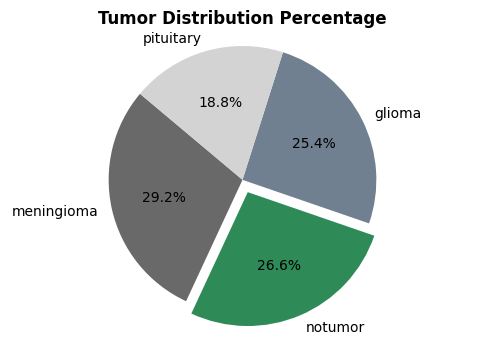

In [8]:
label_counts = test_data['tumor_class'].value_counts().to_dict()  # Count occurrences of each label
total_count = sum(label_counts.values())  
label_percentages = {label: count / total_count * 100 for label, count in label_counts.items()}  

# Create a pie chart
plt.figure(figsize=(6, 4))
colors = ['dimgray','seagreen', 'slategrey', 'lightgray']
explode = (0, 0.1,0,0) #Explode the 1st slice
plt.pie(label_percentages.values(), labels=label_percentages.keys(), autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Tumor Distribution Percentage',weight='bold')
plt.show()

In [9]:
unique_labels = ['glioma','meningioma','notumor','pituitary']

## 4.Data Prepration

### 4.1 Splitting Training Data into Training and Validation Sets:

In [11]:
train_data, val_data = train_test_split(train_data, 
                                               train_size = 0.80, 
                                               random_state = 42, 
                                               stratify = train_data.tumor_class)

In [12]:
print(train_data.shape),
print(val_data.shape),
print(test_data.shape)

(2296, 2)
(574, 2)
(394, 2)


### 4.2. Data Agumentation and Normalization(Rescaling)

In [14]:
image_size = 128
batch_size = 32  # nr of samples(images) in each batch during the training

train_image_datagen_kwargs = dict(rescale = 1 / 255,  
                                #rotation_range = 15, 
                                #width_shift_range = 0.1, 
                                #zoom_range = 0.01, 
                                #shear_range = 0.01,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                brightness_range = [0.3, 1.5],
                                horizontal_flip = True,
                                vertical_flip = True,
                                fill_mode = "nearest"
                                )

test_image_datagen_kwargs = dict(rescale = 1 / 255) # only rescale on test

### 4.3 Data Generator

In [15]:
train_image_datagen = ImageDataGenerator(**train_image_datagen_kwargs) #generating batches of training data with augmentation.
val_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs)#generating batches of validation data without augmentation.
test_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs)#generating batches of test data without augmentation.

- flow_from_dataframe allows you to apply these augmentations on-the-fly during training.

In [16]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,  
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')

val_dataset = val_image_datagen.flow_from_dataframe(val_data, 
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')


test_dataset = test_image_datagen.flow_from_dataframe(test_data, 
                                                      x_col = 'image_filepaths', 
                                                      y_col = 'tumor_class', 
                                                      seed = 42, 
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
Found 394 validated image filenames belonging to 4 classes.


In [17]:
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 10)

## 5. Model Building

### 5.1 VGG16

In [18]:
base_model = VGG16(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet') 
# Set all layers to non-trainable
for layer in base_model.layers:  # loop through all layers in VGG16
    layer.trainable = False    
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True   #unfreeze the last 3 layers
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True


# build a custom model of VGG16
model = Sequential()    
model.add(Input(shape=(image_size,image_size,3))) # add input layer with the specified shape
model.add(base_model) #Adds the pre-trained VGG16 base model to the model.
model.add(Flatten())  #Flattens the output of the VGG16 base
model.add(Dropout(0.3)) # Applies dropout with a rate of 0.3 to reduce overfitting.
model.add(Dense(128, activation='relu')) # Adds a fully connected layer with 128 units and ReLU activation.
model.add(Dropout(0.2)) # Applies another dropout with a rate of 0.2.
model.add(Dense(len(unique_labels), activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

In [30]:
# Specify the directory where you want to save the checkpoints
checkpoint_dir = r"C:\Users\tmost\Documents\Data-course\Brain\Model-Checkpoints\vgg"

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Calculate the checkpoint interval
ckp_interval = 2 * int(np.ceil(train_data.shape[0] / batch_size))

# Define the checkpoint path
ckp_path = os.path.join(checkpoint_dir, "epocch_{epoch:02d}.hdf5")

# Create the ModelCheckpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    verbose=1,
    save_freq=ckp_interval
)


In [31]:
%%time
train_history = model.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 20,
                          callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/20
72/72 [==============================] - 421s 6s/step - loss: 0.3391 - categorical_accuracy: 0.8711 - val_loss: 0.5039 - val_categorical_accuracy: 0.8031
Epoch 2/20
71/72 [============================>.] - ETA: 4s - loss: 0.3346 - categorical_accuracy: 0.8693
Epoch 2: saving model to C:\Users\tmost\Documents\Data-course\Brain\Model-Checkpoints\vgg\epocch_02.hdf5
72/72 [==============================] - 416s 6s/step - loss: 0.3355 - categorical_accuracy: 0.8689 - val_loss: 0.3019 - val_categorical_accuracy: 0.8902
Epoch 3/20
72/72 [==============================] - 406s 6s/step - loss: 0.2929 - categorical_accuracy: 0.8876 - val_loss: 0.3201 - val_categorical_accuracy: 0.8833
Epoch 4/20
71/72 [============================>.] - ETA: 4s - loss: 0.2696 - categorical_accuracy: 0.8949
Epoch 4: saving model to C:\Users\tmost\Documents\Data-course\Brain\Model-Checkpoints\vgg\epocch_04.hdf5
72/72 [==============================] - 405s 6s/step - loss: 0.2692 - categorical_accuracy: 0

In [32]:
print(train_history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


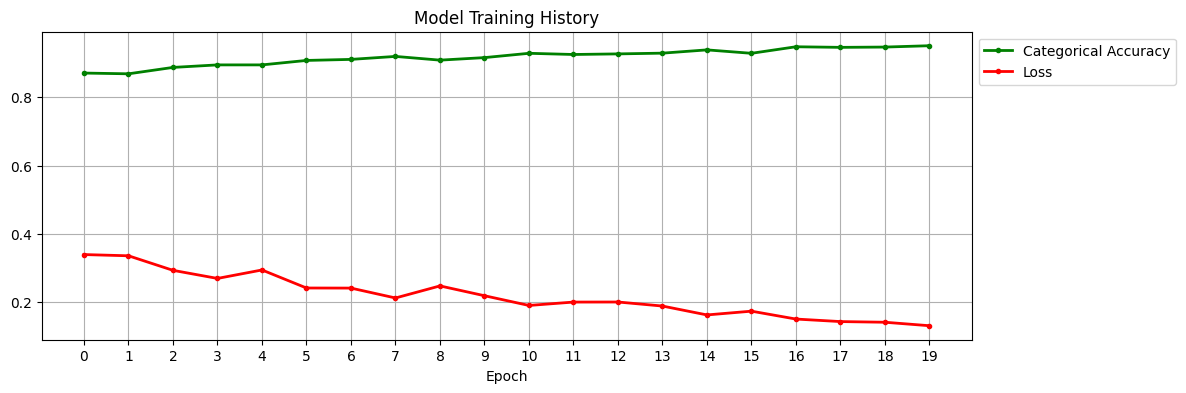

In [33]:
plt.figure(figsize=(12, 4))
plt.grid(True)
plt.plot(train_history.history['categorical_accuracy'], '.g-', linewidth=2, label='Categorical Accuracy')
plt.plot(train_history.history['loss'], '.r-', linewidth=2, label='Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history.history['categorical_accuracy'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

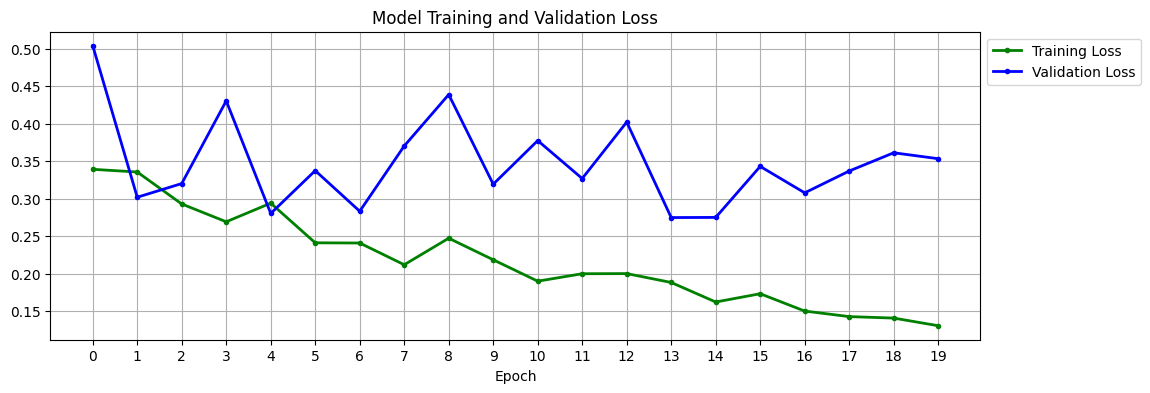

In [34]:
plt.figure(figsize=(12, 4))
plt.grid(True)

# Plot training loss
plt.plot(train_history.history['loss'], '.g-', label='Training Loss', linewidth=2)

# Plot validation loss if available
if 'val_loss' in train_history.history:
    plt.plot(train_history.history['val_loss'], '.b-', label='Validation Loss', linewidth=2)

plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(train_history.history['loss'])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
## Evaluate the Model

In [35]:
# Evaluate the model on the test set
evaluation_results = model.evaluate(train_dataset)

# Print the evaluation results
print(f'Test Loss: {evaluation_results[0]}')
print(f'Test Accuracy: {evaluation_results[1]}')

72/72 [==============================] - 232s 3s/step - loss: 0.1829 - categorical_accuracy: 0.9325
Test Loss: 0.18292111158370972
Test Accuracy: 0.9324913024902344


In [36]:
y_perd = model.predict(train_dataset)

72/72 [==============================] - 233s 3s/step


In [38]:
y_perd

array([[7.7792543e-11, 1.0000000e+00, 5.5689077e-12, 2.3811619e-10],
       [8.8641327e-03, 9.8676711e-01, 1.0659015e-05, 4.3579829e-03],
       [9.9883312e-01, 1.1369806e-03, 2.4168648e-07, 2.9706605e-05],
       ...,
       [7.6264301e-03, 9.9231154e-01, 3.1830764e-06, 5.8815949e-05],
       [1.5046823e-04, 4.2320066e-03, 5.0549148e-05, 9.9556690e-01],
       [4.5337165e-03, 9.8610771e-01, 3.9840641e-05, 9.3187550e-03]],
      dtype=float32)

<Axes: >

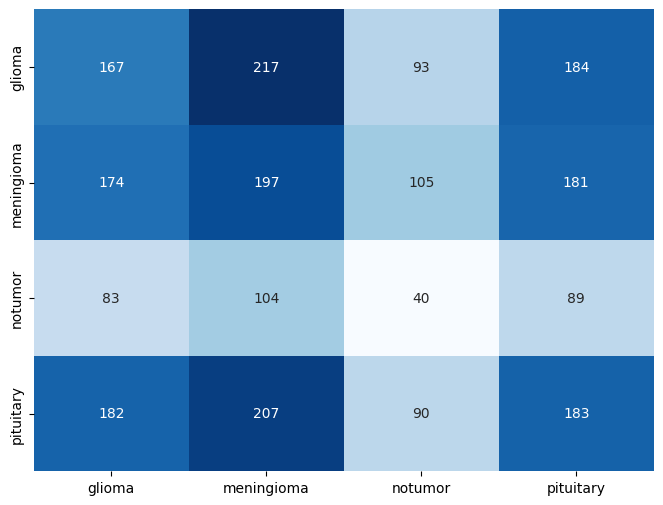

In [39]:
# confusion_matrix
conf_matrix = confusion_matrix(train_dataset.labels,np.argmax(y_perd,axis=-1))
conf_matrix_data = np.array(conf_matrix)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)